# **Table of Contents**

1. Global Constants

2. Dependences

3. Spark and Google Colab Setup
    
    3.1. Create Spark context

    3.2. Link Colab to our Google Drive

    3.3. Check everything is ok

4. Bitcoin Address Clustering

    4.1. Bitcoin Block Overview

    4.2. Data Collection

    4.3. Transaction Graph generation

    4.4. Look inside the blockchain
    
    4.5. Implementation of Heuristics

5. Results
    
    5.1. Overview

    5.2. Assumption

    5.3. Overview after Assumption

6. Boosting Bitcoin Address Clustering with other more complex techniques

    6.1. Merge or Demerge clusters thanks to off-chain informations

    6.2. Louvain community detection algorithm

7. Use cases

    7.1. Visualize entity movements from an address

    7.2. Solve specific Queries

8. Web App






# **Abstract**
The main goal of the project is to obtain information from the Bitcoin blockchain. Specifically, the project wants to manipulate the information extrapolated from the Bitcoin blockchain to create the transaction graph and use it to perform chain analysis. Bitcoin address clustering based on multiple heuristic conditions is the core of chain analysis.

The project can be summarized in the following points:
- Blockchain overview (4.1.)
- construction of the dataset created starting from the Bitcoin blockchain (4.2.)
- creation of the transaction graph starting from the dataset. The nodes of the graph are the transactions, the input edges are the input UTXOs to the transaction, and the output edges are the transaction output UTXOs (4.3.)
- perform graph analysis (4.4.)
- implementation of heuristics: (4.5. Implementation of Heuristics)
    - Satoshi heuristic
    - Coinbase transaction mining address clustering heuristic
    - Common-input-ownership heuristic
    - Single input and single output heuristic
    - Consolidation transaction heuristic
    - Payment transaction with amount payed and change address heuristic
    - Change address detection heuristic
        - same address in input and output heuristic
        - address reuse heuristic
        - Unnecessary input heuristic
        - new address in output heuristic
        - round number heuristic
    - Mixed transaction recognition heuristic
        - taint analysis and coinjoin sudoku
- discussion about busting bitcoin address clustering (6.)
    - Merge or Demerge clusters thanks to off-chain informations
    - Louvain community detection algorithm
- perform chain analysis use cases (7.)

# **1. Global Constants**


In [1]:
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/Bitcoin Address Clustering/dataset"

start_block = 0
end_block = 120000

# **2. Dependences**

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!pip install wget
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 35.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=a10b673b7cdb7f2775f929675c1897cb907a83e9a68534a15bee4d01ddcef818
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d56e8cc83bd8bbb818dd6c78292d51197f326c0c90d53ca5aa455e4a9052ecf7
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for

In [3]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from google.colab import drive
import requests
import pprint
import codecs
import builtins
import wget
import csv
import os
from urllib import request
from urllib.error import HTTPError
import networkx as nx
import matplotlib.pyplot as plt
import shutil
from pyvis.network import Network

# **3. Spark and Google Colab Setup**

## **3.1.** Create Spark context

In [4]:
# create the session
conf = SparkConf()\
                .set('spark.executor.memory', '50G')\
                .set('spark.driver.memory', '50G')\
                .set('spark.driver.maxResultSize', '50G')\
                .set("spark.driver.cores", "10")\
                .set("spark.sql.analyzer.maxIterations", "100000")

# create the context
sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **3.2.** Link Colab to our Google Drive

In [5]:
# Point Colaboratory to our Google Drive
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


## **3.3.** Check everything is ok

In [6]:
spark

In [7]:
sc._conf.getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.submitTime', '1656299010933'),
 ('spark.executor.memory', '50G'),
 ('spark.driver.cores', '10'),
 ('spark.sql.analyzer.maxIterations', '100000'),
 ('spark.app.id', 'local-1656299013321'),
 ('spark.executor.id', 'driver')

# **4. Bitcoin Address Clustering**

## **4.1.** Bitcoin Block Overview
In this section, we see what is inside a bitcoin block and we recognize the useful informations to be extrapolated for our purpose

### **4.1.1.** Make a request to [Blockchain.info](https://blockchain.info) to get a raw bitcoin block


In [8]:
block_height = 0
response = requests.get('https://blockchain.info/block-height/{}'.format(block_height))
pprint.PrettyPrinter().pprint(response.json())

{'blocks': [{'bits': 486604799,
             'block_index': 0,
             'fee': 0,
             'hash': '000000000019d6689c085ae165831e934ff763ae46a2a6c172b3f1b60a8ce26f',
             'height': 0,
             'main_chain': True,
             'mrkl_root': '4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc77ab2127b7afdeda33b',
             'n_tx': 1,
             'next_block': ['00000000839a8e6886ab5951d76f411475428afc90947ee320161bbf18eb6048'],
             'nonce': 2083236893,
             'prev_block': '0000000000000000000000000000000000000000000000000000000000000000',
             'size': 285,
             'time': 1231006505,
             'tx': [{'block_height': 0,
                     'block_index': 0,
                     'double_spend': False,
                     'fee': 0,
                     'hash': '4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc77ab2127b7afdeda33b',
                     'inputs': [{'index': 0,
                                 'prev_out': {'n': 4294967295,
    

### **4.1.2.** The Times 03/Jan/2009 Chancellor on brink of second bailout for banks
Translating the hexadecimal script present in the first transaction of the first block of bitcoin into ASCII, we can read the message from Satoshi Nakamoto


In [9]:
string = response.json()['blocks'][0]['tx'][0]['inputs'][0]['script']
codecs.decode(string, "hex")

b'\x04\xff\xff\x00\x1d\x01\x04EThe Times 03/Jan/2009 Chancellor on brink of second bailout for banks'

### **4.1.3.** Block's usefull information


In [10]:
block = response.json()['blocks'][0]
block_height = block['height']
block_hash = block['hash']
TXs_list = block['tx']
print('block_height:', block_height)
print('block_hash:', block_hash)
print('TXs_list:')
pprint.PrettyPrinter().pprint(TXs_list)

block_height: 0
block_hash: 000000000019d6689c085ae165831e934ff763ae46a2a6c172b3f1b60a8ce26f
TXs_list:
[{'block_height': 0,
  'block_index': 0,
  'double_spend': False,
  'fee': 0,
  'hash': '4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc77ab2127b7afdeda33b',
  'inputs': [{'index': 0,
              'prev_out': {'n': 4294967295,
                           'script': '',
                           'spending_outpoints': [{'n': 0,
                                                   'tx_index': 2098408272645986}],
                           'spent': True,
                           'tx_index': 0,
                           'type': 0,
                           'value': 0},
              'script': '04ffff001d0104455468652054696d65732030332f4a616e2f32303039204368616e63656c6c6f72206f6e206272696e6b206f66207365636f6e64206261696c6f757420666f722062616e6b73',
              'sequence': 4294967295,
              'witness': ''}],
  'lock_time': 0,
  'out': [{'addr': '1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa',


### **4.1.4.** Transaction's usefull information

In [11]:
TX = TXs_list[0]
tx_id = TX['tx_index']
tx_hash = TX['hash']
fee = TX['fee']
n_input = len(TX['inputs'])
amount_input = builtins.sum([UTXO['prev_out']['value'] for UTXO in TX['inputs']])
n_output = len(TX['out'])
amount_output = builtins.sum([UTXO['value'] for UTXO in TX['out']])
print('tx_id:', tx_id)
print('tx_hash:', tx_hash)
print('fee:', fee)
print('n_input:', n_input)
print('amount_input:', amount_input)
print('n_output:', n_output)
print('amount_output:', amount_output)

tx_id: 2098408272645986
tx_hash: 4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc77ab2127b7afdeda33b
fee: 0
n_input: 1
amount_input: 0
n_output: 1
amount_output: 5000000000


### **4.1.5.** UTXO's usefull information

In [12]:
#UTXO in input
input_UTXO = TXs_list[0]['inputs'][0]
src_position = input_UTXO['prev_out']['n']
dst_position = input_UTXO['index']
try:
    address = input_UTXO['prev_out']['addr']
except KeyError:
    address = 'coinbase'
value = input_UTXO['prev_out']['value']
print('input_UTXO src_position:', src_position)
print('input_UTXO dst_position:', dst_position)
print('input_UTXO address:', address)
print('input_UTXO value:', value)

#UTXO in output
output_UTXO = TXs_list[0]['out'][0]
src_position = output_UTXO['tx_index']
try:
    dst_position = output_UTXO['spending_outpoints'][0]['n']
except IndexError:
    dst_position = 'unspent'
address = output_UTXO['addr']
value = output_UTXO['value']
print('output_UTXO src_position:', src_position)
print('output_UTXO dst_position:', dst_position)
print('output_UTXO address:', address)
print('output_UTXO value:', value)

input_UTXO src_position: 4294967295
input_UTXO dst_position: 0
input_UTXO address: coinbase
input_UTXO value: 0
output_UTXO src_position: 2098408272645986
output_UTXO dst_position: unspent
output_UTXO address: 1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa
output_UTXO value: 5000000000


## **4.2.** Data Collection
perform data collection and load dataset in spark dataframes

In [13]:
def download_dataset(start_block, end_block, directory, spark_session, debug=False):

    if 'blocks-{}-{}'.format(start_block, end_block) in os.listdir(directory):
        # dataset is already in directory
        d_path = os.path.join(directory, 'blocks-{}-{}'.format(start_block, end_block))
        v_path = os.path.join(d_path, 'vertices-{}-{}'.format(start_block, end_block))
        e_path = os.path.join(d_path, 'edges-{}-{}'.format(start_block, end_block))
        a_path = os.path.join(d_path, 'addresses-{}-{}'.format(start_block, end_block))
        if debug: print('dataset is already in {}'.format(d_path))

    else:

        d_path = os.path.join(directory, 'blocks-{}-{}'.format(start_block, end_block))
        os.mkdir(d_path)

        try:
            # try to dump dataset from github repo datasets
            v_path = os.path.join(d_path, 'vertices-{}-{}'.format(start_block, end_block))
            e_path = os.path.join(d_path, 'edges-{}-{}'.format(start_block, end_block))
            a_path = os.path.join(d_path, 'addresses-{}-{}'.format(start_block, end_block))
            wget.download('https://raw.github.com/VincenzoImp/Bitcoin-Address-Clustering/master/dataset/blocks-{}-{}/vertices-{}-{}.tar.gz'.format(start_block, end_block, start_block, end_block), out=d_path)
            wget.download('https://raw.github.com/VincenzoImp/Bitcoin-Address-Clustering/master/dataset/blocks-{}-{}/edges-{}-{}.tar.gz'.format(start_block, end_block, start_block, end_block), out=d_path)
            wget.download('https://raw.github.com/VincenzoImp/Bitcoin-Address-Clustering/master/dataset/blocks-{}-{}/addresses-{}-{}.tar.gz'.format(start_block, end_block, start_block, end_block), out=d_path)
            os.system('tar -xf '+v_path.replace(' ', '\ ')+'.tar.gz -C '+d_path.replace(' ', '\ '))
            os.system('tar -xf '+e_path.replace(' ', '\ ')+'.tar.gz -C '+d_path.replace(' ', '\ '))
            os.system('tar -xf '+a_path.replace(' ', '\ ')+'.tar.gz -C '+d_path.replace(' ', '\ '))
            os.remove(v_path+'.tar.gz')
            os.remove(e_path+'.tar.gz')
            os.remove(a_path+'.tar.gz')
            if debug: print('dataset downloaded from https://github.com/VincenzoImp/Bitcoin-Address-Clustering/master/dataset/blocks-{}-{}'.format(start_block, end_block))

        except HTTPError: 
            # dump dataset manually
            v_path = os.path.join(d_path, 'vertices-{}-{}.csv'.format(start_block, end_block))
            e_path = os.path.join(d_path, 'edges-{}-{}.csv'.format(start_block, end_block))

            if debug: print('dumping blocks...')

            v_columns = ['id', 'note', 'tx_hash', 'block_height', 'block_hash', 'fee', 'n_input', 'amount_input', 'n_output', 'amount_output', 'temporal_index']
            e_columns = ['src_id', 'dst_id', 'src_position', 'dst_position', 'address', 'value']


            temporal_index = 0
            count_UXTO = 0

            with open(v_path, 'w', encoding='UTF8') as v_file:
                with open(e_path, 'w', encoding='UTF8') as e_file:
                    
                    csv.writer(v_file).writerow(v_columns)
                    csv.writer(e_file).writerow(e_columns)
                    
                    # for each block read all transactions, extract usefull information and write them locally
                    for block_height in range(start_block, end_block+1):    

                        if debug and block_height % 250 == 0:
                            if end_block < block_height+249:
                                print('from block {} to block {}'.format(block_height, end_block))
                            else:
                                print('from block {} to block {}'.format(block_height, block_height+249))

                        block_reward = (5000000000 // 2**(block_height//210000))
                        # save coinbase information as vertex
                        csv.writer(v_file).writerow(['coinbase'+str(block_height), 'coinbase', '', -1, '', 0, 0, 0, 1, block_reward, -1])

                        loop = True 
                        while loop:
                            try:
                                response = requests.get('https://blockchain.info/block-height/{}'.format(block_height))
                                if response.status_code == 200: loop = False
                            except HTTPError:
                                pass

                        block_hash = response.json()['blocks'][0]['hash']

                        # read each transaction from a specific json block
                        for tx in response.json()['blocks'][0]['tx']:

                            tx_id = tx['tx_index']
                            tx_hash = tx['hash']
                            fee = tx['fee']
                            n_input = 0
                            amount_input = 0
                            n_output = 0
                            amount_output = 0

                            for incoming_edge in tx['inputs']:
                                # consider UTXOs in input
                                src_id = incoming_edge['prev_out']['tx_index']
                                src_position = incoming_edge['prev_out']['n']

                                dst_id = tx_id
                                dst_position = incoming_edge['index']

                                if src_id == 0:
                                    src_id = 'coinbase' + str(block_height)
                                    address = 'coinbase' + str(block_height)
                                    value = block_reward
                                else:
                                    try:
                                        address = incoming_edge['prev_out']['addr']
                                    except KeyError:
                                        continue
                                    value = incoming_edge['prev_out']['value']

                                n_input += 1
                                amount_input += value
                                
                                # save spent UTXO information as edge
                                csv.writer(e_file).writerow([str(src_id), str(dst_id), src_position, dst_position, address, value])

                            for outgoing_edge in tx['out']:
                                # consider UTXOs in output
                                src_id = tx_id
                                src_position = outgoing_edge['n']

                                if outgoing_edge['spending_outpoints'] == []:
                                    dst_id = 'UTXO'+str(count_UXTO)
                                    count_UXTO += 1
                                    dst_position = -1
                                else:
                                    dst_id = outgoing_edge['spending_outpoints'][0]['tx_index']
                                    dst_position = outgoing_edge['spending_outpoints'][0]['n']

                                try:
                                    address = outgoing_edge['addr']
                                except KeyError:
                                    continue

                                value = outgoing_edge['value']

                                n_output += 1
                                amount_output += value

                                #save spent UTXO information as edge
                                csv.writer(e_file).writerow([str(src_id), str(dst_id), src_position, dst_position, address, value])

                                if dst_id == 'UTXO'+str(count_UXTO-1):
                                    #save unspend UTXO information as vertex
                                    csv.writer(v_file).writerow([str(dst_id), 'UTXO', '', -1, '', 0, 1, value, 0, 0, -1])
                            
                            # save transaction information as vertex
                            csv.writer(v_file).writerow([str(tx_id), 'tx', tx_hash, block_height, block_hash, fee, n_input, amount_input, n_output, amount_output, temporal_index])
                            temporal_index += 1

            # genetare dataframes and save them locally
            v_df = spark_session.read.load(v_path, 
                                    format="csv", 
                                    sep=",", 
                                    inferSchema="true", 
                                    header="true"
                                    ).distinct()
            e_df = spark_session.read.load(e_path, 
                                    format="csv", 
                                    sep=",", 
                                    inferSchema="true",
                                    header="true"
                                    ).distinct()

            e_df.createOrReplaceTempView('EDGES')
            a_df = e_df.select('address').subtract(spark_session.sql("select address from EDGES where address like 'coinbase%'"))
            a_df = a_df.withColumn('cluster_id', monotonically_increasing_id())

            v_path = os.path.join(d_path, 'vertices-{}-{}'.format(start_block, end_block))
            e_path = os.path.join(d_path, 'edges-{}-{}'.format(start_block, end_block))
            a_path = os.path.join(d_path, 'addresses-{}-{}'.format(start_block, end_block))

            v_df.write.save(path=v_path, format='csv', header='True')
            e_df.write.save(path=e_path, format='csv', header='True')
            a_df.write.save(path=a_path, format='csv', header='True')

            os.remove(os.path.join(d_path, 'vertices-{}-{}.csv'.format(start_block, end_block)))
            os.remove(os.path.join(d_path, 'edges-{}-{}.csv'.format(start_block, end_block)))

            if debug: print('dataset downloaded')
    
    # return dataset files paths
    return v_path, e_path, a_path, d_path

In [14]:
v_path, e_path, a_path, d_path = download_dataset(start_block, end_block, GDRIVE_DATA_DIR, spark, True)

dataset downloaded from https://github.com/VincenzoImp/Bitcoin-Address-Clustering/master/dataset/blocks-0-120000


In [15]:
v_df = spark.read.load(v_path, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )
e_df = spark.read.load(e_path, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )
a_df = spark.read.load(a_path, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )
unknown_v_df = e_df.select('src_id').union(e_df.select('dst_id')).distinct().subtract(v_df.select('id')).withColumnRenamed('src_id', 'id')
unknown_v_df = unknown_v_df.withColumn('note', lit('unknown_tx')) \
                          .withColumn('tx_hash', lit(None)) \
                          .withColumn('block_height', lit(-1)) \
                          .withColumn('block_hash', lit(None)) \
                          .withColumn('fee', lit(0)) \
                          .withColumn('n_input', lit(0)) \
                          .withColumn('amount_input', lit(0)) \
                          .withColumn('n_output', lit(0)) \
                          .withColumn('amount_output', lit(0)) \
                          .withColumn('temporal_index', lit(-1))
                          
v_df = v_df.union(unknown_v_df)

v_df.createOrReplaceTempView('VERTICES')
known_tx_df = spark.sql("select * from VERTICES where note = 'tx'")

In [16]:
print("Total nodes: {}".format(v_df.count()))
print("Total edges: {}".format(e_df.count()))
print("Total addresses: {}".format(a_df.count()))
print("Total known transactions: {}".format(known_tx_df.count()))

Total nodes: 644770
Total edges: 774633
Total addresses: 416792
Total known transactions: 435536


In [17]:
v_df.printSchema()
e_df.printSchema()
a_df.printSchema()
known_tx_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- note: string (nullable = true)
 |-- tx_hash: string (nullable = true)
 |-- block_height: integer (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- fee: integer (nullable = true)
 |-- n_input: integer (nullable = true)
 |-- amount_input: long (nullable = true)
 |-- n_output: integer (nullable = true)
 |-- amount_output: long (nullable = true)
 |-- temporal_index: integer (nullable = true)

root
 |-- src_id: string (nullable = true)
 |-- dst_id: string (nullable = true)
 |-- src_position: long (nullable = true)
 |-- dst_position: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- value: long (nullable = true)

root
 |-- address: string (nullable = true)
 |-- cluster_id: long (nullable = true)

root
 |-- id: string (nullable = true)
 |-- note: string (nullable = true)
 |-- tx_hash: string (nullable = true)
 |-- block_height: integer (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- fee: integer (n

In [18]:
v_df.show(truncate=False)
e_df.show(truncate=False)
a_df.show(truncate=False)
known_tx_df.show(truncate=False)

+----------------+--------+----------------------------------------------------------------+------------+----------------------------------------------------------------+---+-------+------------+--------+-------------+--------------+
|id              |note    |tx_hash                                                         |block_height|block_hash                                                      |fee|n_input|amount_input|n_output|amount_output|temporal_index|
+----------------+--------+----------------------------------------------------------------+------------+----------------------------------------------------------------+---+-------+------------+--------+-------------+--------------+
|coinbase144     |coinbase|null                                                            |-1          |null                                                            |0  |0      |0           |1       |5000000000   |-1            |
|UTXO173         |UTXO    |null                                 

## **4.3.** Transaction Graph generation

In [19]:
def generate_nx_graph(v_df, e_df, graph_path, start_block, end_block, debug=False):

    graph_name = os.path.basename(graph_path)
    d_path = os.path.dirname(graph_path)
    if graph_name in os.listdir(os.path.dirname(graph_path)):
        # graph is already in directory
        G = nx.read_gexf(graph_path)
        G = nx.MultiDiGraph(G)
        if debug: print('graph is already in {}'.format(d_path))
    else:
        try:
            # try to dump graph from github repo datasets
            request.urlretrieve('https://raw.github.com/VincenzoImp/Bitcoin-Address-Clustering/master/dataset/blocks-{}-{}/{}'.format(start_block, end_block, graph_name), graph_path)
            G = nx.read_gexf(graph_path)
            G = nx.MultiDiGraph(G)
            if debug: print('graph downloaded from https://github.com/VincenzoImp/Bitcoin-Address-Clustering/master/dataset/blocks-{}-{}'.format(start_block, end_block))
        except:
            # generate graph manually
            if debug: print('generating graph...')
            G = nx.MultiDiGraph()

            # add nodes
            for node in v_df.rdd.collect():
                # known transaction node
                if node.note == 'tx':
                    G.add_node(
                        node_for_adding=str(node.id), 
                        note=node.note, 
                        tx_hash=node.tx_hash, 
                        block_height=node.block_height,
                        fee=node.fee/100000000,
                        n_input=node.n_input,
                        amount_input=node.amount_input/100000000,
                        n_output=node.n_output,
                        amount_output=node.amount_output/100000000
                        )
                # UTXO node
                elif node.note == 'UTXO':
                    G.add_node(
                        node_for_adding=str(node.id), 
                        note=node.note,
                        amount=node.amount_input/100000000
                    )
                # Coinbase node
                elif node.note == 'coinbase':
                    G.add_node(
                        node_for_adding=str(node.id), 
                        note=node.note,
                        amount=node.amount_output/100000000
                    )
                # unknown transaction node
                elif node.note == 'unknown_tx':
                    G.add_node(
                        node_for_adding=str(node.id), 
                        note=node.note
                    )
            # add edges
            for edge in e_df.rdd.collect():
                G.add_edge(
                    u_for_edge=str(edge.src_id),
                    v_for_edge=str(edge.dst_id), 
                    key=None,
                    address=edge.address,
                    value=edge.value/100000000,
                )
                
            # save graph in graph_path
            nx.write_gexf(G, graph_path)
            if debug: print('graph generated')

    return G

In [20]:
graph_path = os.path.join(d_path, 'graph-{}-{}.gexf.bz2'.format(start_block, end_block))
nx_graph = generate_nx_graph(v_df, e_df, graph_path, start_block, end_block, True)

graph downloaded from https://github.com/VincenzoImp/Bitcoin-Address-Clustering/master/dataset/blocks-0-120000


## **4.4.** Look inside the blockchain

In [21]:
print("Total nodes: {}".format(v_df.count()))
print("Total edges: {}".format(e_df.count()))
print("Total addresses: {}".format(a_df.count()))
print("Total known transactions: {}".format(known_tx_df.count()))

Total nodes: 644770
Total edges: 774633
Total addresses: 416792
Total known transactions: 435536


### **4.4.1.** Connected Components

In [22]:
cc = [nx_graph.subgraph(c).copy() for c in nx.connected_components(nx_graph.to_undirected())]
tmp_list = [(i, len(c.nodes()), len(c.edges())) for i, c in enumerate(cc)]
cc_df = spark.createDataFrame(data = tmp_list, schema = ['id', 'num_nodes', 'num_edges'])

In [23]:
print(cc_df.count())
cc_df.printSchema()
cc_df.show()

39144
root
 |-- id: long (nullable = true)
 |-- num_nodes: long (nullable = true)
 |-- num_edges: long (nullable = true)

+---+---------+---------+
| id|num_nodes|num_edges|
+---+---------+---------+
|  0|        3|        2|
|  1|        3|        2|
|  2|        3|        2|
|  3|        3|        2|
|  4|        3|        2|
|  5|        3|        2|
|  6|        3|        2|
|  7|        3|        2|
|  8|        3|        2|
|  9|        3|        2|
| 10|     2939|     2940|
| 11|        3|        2|
| 12|        3|        2|
| 13|        3|        2|
| 14|        3|        2|
| 15|        3|        2|
| 16|        3|        2|
| 17|        3|        2|
| 18|        3|        2|
| 19|        3|        2|
+---+---------+---------+
only showing top 20 rows



In [24]:
cc_df.createOrReplaceTempView('CC')
statistics_cc_df = spark.sql("select num_nodes, num_edges, count(num_nodes, num_edges) as n_components from CC group by num_nodes, num_edges order by num_nodes, num_edges")

In [25]:
print(statistics_cc_df.count())
statistics_cc_df.printSchema()
statistics_cc_df.show(statistics_cc_df.count(), truncate=False)

146
root
 |-- num_nodes: long (nullable = true)
 |-- num_edges: long (nullable = true)
 |-- n_components: long (nullable = false)

+---------+---------+------------+
|num_nodes|num_edges|n_components|
+---------+---------+------------+
|3        |2        |36463       |
|4        |3        |541         |
|4        |4        |2           |
|5        |4        |433         |
|5        |5        |1           |
|6        |5        |152         |
|6        |6        |5           |
|7        |6        |219         |
|7        |7        |3           |
|7        |8        |1           |
|8        |7        |74          |
|8        |8        |3           |
|8        |10       |1           |
|9        |8        |149         |
|9        |9        |5           |
|10       |9        |68          |
|10       |11       |1           |
|10       |12       |1           |
|11       |10       |68          |
|11       |12       |1           |
|12       |11       |30          |
|12       |12       |2       

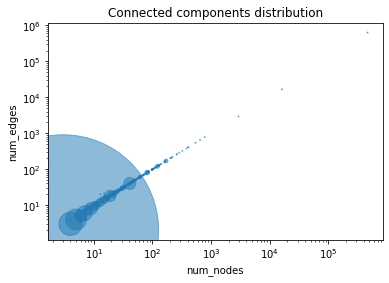

In [26]:
plt.scatter(
    x = statistics_cc_df.toPandas()['num_nodes'], 
    y = statistics_cc_df.toPandas()['num_edges'], 
    s=statistics_cc_df.toPandas()['n_components'], 
    alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("num_nodes")
plt.ylabel("num_edges")
plt.title("Connected components distribution")
plt.show()

### **4.4.2.** Indegree and Outdegree of Known Transactions

In [27]:
in_degree_df = spark.createDataFrame(nx_graph.in_degree(nx_graph.nodes()), schema=['id1', 'in_degree'])
out_degree_df = spark.createDataFrame(nx_graph.out_degree(nx_graph.nodes()), schema=['id2', 'out_degree'])
known_tx_degree_df = in_degree_df.join(out_degree_df, in_degree_df.id1 == out_degree_df.id2, 'inner')
known_tx_degree_df = known_tx_degree_df.join(known_tx_df, known_tx_degree_df.id1 == known_tx_df.id, 'inner')
known_tx_degree_df = known_tx_degree_df.select('id', 'in_degree', 'out_degree')

In [28]:
print(known_tx_degree_df.count())
known_tx_degree_df.printSchema()
known_tx_degree_df.show(truncate=False)

435536
root
 |-- id: string (nullable = true)
 |-- in_degree: long (nullable = true)
 |-- out_degree: long (nullable = true)

+----------------+---------+----------+
|id              |in_degree|out_degree|
+----------------+---------+----------+
|10000567111143  |1        |2         |
|1000074716619543|1        |2         |
|1000098156582822|1        |2         |
|1000182559678696|2        |2         |
|1000256315544922|1        |1         |
|1000294890855257|1        |1         |
|1000316896728232|1        |2         |
|1000329749074483|1        |1         |
|100034959355395 |1        |2         |
|100048939499623 |1        |1         |
|1000536850057403|2        |1         |
|10005377111127  |1        |2         |
|1000545195622952|1        |2         |
|1000569048420985|1        |1         |
|1000588116506381|1        |1         |
|1000662484810469|1        |1         |
|1000674308409559|1        |1         |
|100071165553466 |1        |2         |
|1000754437156666|1        |2     

In [29]:
known_tx_degree_df.createOrReplaceTempView('KNOWN_TX_DEGREE')
statistics_known_tx_degree_df = spark.sql("select in_degree, out_degree, count(in_degree, out_degree) as n_txs from KNOWN_TX_DEGREE group by in_degree, out_degree order by in_degree, out_degree")

In [30]:
print(statistics_known_tx_degree_df.count())
statistics_known_tx_degree_df.printSchema()
statistics_known_tx_degree_df.show(statistics_known_tx_degree_df.count(), truncate=False)

539
root
 |-- in_degree: long (nullable = true)
 |-- out_degree: long (nullable = true)
 |-- n_txs: long (nullable = false)

+---------+----------+------+
|in_degree|out_degree|n_txs |
+---------+----------+------+
|1        |1         |217998|
|1        |2         |174537|
|1        |3         |10    |
|1        |4         |2     |
|1        |5         |2     |
|1        |6         |2     |
|1        |8         |1     |
|1        |14        |1     |
|1        |16        |2     |
|1        |17        |6     |
|1        |18        |3     |
|1        |19        |6     |
|1        |20        |11    |
|1        |21        |5     |
|1        |22        |7     |
|1        |23        |16    |
|1        |24        |10    |
|1        |25        |11    |
|1        |26        |11    |
|1        |27        |9     |
|1        |28        |9     |
|1        |29        |5     |
|1        |30        |3     |
|1        |31        |4     |
|1        |32        |3     |
|1        |33        |6     |
|1   

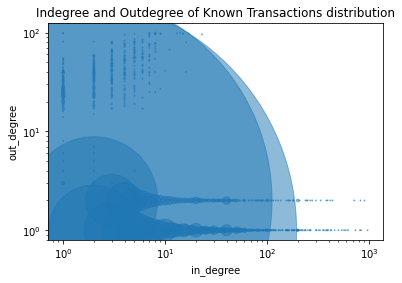

In [31]:
plt.scatter(
    x = statistics_known_tx_degree_df.toPandas()['in_degree'], 
    y = statistics_known_tx_degree_df.toPandas()['out_degree'], 
    s=statistics_known_tx_degree_df.toPandas()['n_txs'], 
    alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("in_degree")
plt.ylabel("out_degree")
plt.title("Indegree and Outdegree of Known Transactions distribution")
plt.show()

visualize known transaction distribution based on out_degree

In [32]:
statistics_known_tx_degree_df.createOrReplaceTempView('STAT_KNOWN_TX_DEGREE')
tmp_df = spark.sql("select out_degree, sum(n_txs) as n_txs from STAT_KNOWN_TX_DEGREE group by out_degree order by out_degree")

In [33]:
tmp_df.show(tmp_df.count(), truncate=False)

+----------+------+
|out_degree|n_txs |
+----------+------+
|1         |238103|
|2         |196849|
|3         |15    |
|4         |4     |
|5         |3     |
|6         |3     |
|7         |1     |
|8         |1     |
|14        |1     |
|15        |1     |
|16        |2     |
|17        |10    |
|18        |9     |
|19        |13    |
|20        |14    |
|21        |6     |
|22        |17    |
|23        |28    |
|24        |19    |
|25        |18    |
|26        |19    |
|27        |21    |
|28        |18    |
|29        |8     |
|30        |9     |
|31        |8     |
|32        |12    |
|33        |13    |
|34        |14    |
|35        |13    |
|36        |7     |
|37        |12    |
|38        |7     |
|39        |21    |
|40        |18    |
|41        |11    |
|42        |12    |
|43        |7     |
|44        |5     |
|45        |10    |
|46        |6     |
|47        |8     |
|48        |6     |
|49        |9     |
|50        |2     |
|51        |6     |
|52        |7     |


visualize known transaction distribution based on in_degree

In [34]:
statistics_known_tx_degree_df.createOrReplaceTempView('STAT_KNOWN_TX_DEGREE')
tmp_df = spark.sql("select in_degree, sum(n_txs) as n_txs from STAT_KNOWN_TX_DEGREE group by in_degree order by in_degree")

In [35]:
tmp_df.show(tmp_df.count(), truncate=False)

+---------+------+
|in_degree|n_txs |
+---------+------+
|1        |392718|
|2        |24561 |
|3        |5917  |
|4        |3383  |
|5        |1919  |
|6        |1248  |
|7        |823   |
|8        |637   |
|9        |469   |
|10       |566   |
|11       |295   |
|12       |253   |
|13       |182   |
|14       |153   |
|15       |188   |
|16       |160   |
|17       |85    |
|18       |109   |
|19       |90    |
|20       |230   |
|21       |57    |
|22       |78    |
|23       |58    |
|24       |48    |
|25       |80    |
|26       |44    |
|27       |40    |
|28       |42    |
|29       |41    |
|30       |83    |
|31       |18    |
|32       |40    |
|33       |25    |
|34       |26    |
|35       |21    |
|36       |36    |
|37       |24    |
|38       |34    |
|39       |26    |
|40       |181   |
|41       |20    |
|42       |16    |
|43       |14    |
|44       |20    |
|45       |12    |
|46       |18    |
|47       |17    |
|48       |10    |
|49       |13    |
|50       |5

## **4.5.** Implementation of Heuristics

### **4.5.1.** Multiple interpretations of a blockchain transaction


Bitcoin transactions are made up of inputs and outputs, of which there can be one or more. Previously-created outputs can be used as inputs for later transactions. Such outputs are destroyed when spent and new unspent outputs are usually created to replace them.

Consider this example transaction:

    1 btc  ---->  1 btc 
    3 btc         3 btc
This transaction has two inputs, worth 1 btc and 3 btc, and creates two outputs also worth 1 btc and 3 btc.

If you were to look at this on the blockchain, what would you assume is the meaning of this transaction? (for example, we usually assume a bitcoin transaction is a payment but it doesn't have to be).

There are at least nine' possible interpretations:

1. Alice provides both inputs and pays 3 btc to Bob. Alice owns the 1 btc output (i.e. it is a change output).
2. Alice provides both inputs and pays 1 btc to Bob, with 3 btc paid back to Alice as the change.
3. Alice provides 1 btc input and Bob provides 3 btc input, Alice gets 1 btc output and Bob gets 3 btc output. This is a kind of CoinJoin transaction.
4. Alice pays 2 btc to Bob. Alice provides 3 btc input, gets the 1 btc output; Bob provides 1 btc input and gets 3 btc. This would be a PayJoin transaction type.
5. Alice pays 4 btc to Bob (but using two outputs for some reason).
6. Fake transaction - Alice owns all inputs and outputs, and is simply moving coins between her own addresses.
7. Alice pays Bob 3 btc and Carol 1 btc. This is a batched payment with no change address.
8. Alice pays 3, Bob pays 1; Carol gets 3 btc and David gets 1 btc. This is some kind of CoinJoined batched payment with no change address.
9. Alice and Bob pay 4 btc to Carol (but using two outputs).

### **4.5.2.** Heuristics Implemented

**NOTE**

The heuristics have been implemented in order to avoid as much as possible the grouping of addresses of two different entities. So two addresses are grouped if there is a strong probability that the grouping is correct



**Satoshi heuristic**

It is estimated that satoshi, in the first months of 2009, lowered more than 1,000,000 BTC which he still keeps and does not spend. Therefore the output addresses of a coinbase transaction are comparable to satoshi with reasonable certainty only if it is a coinbase transaction with block_height < 21000 and, the mined bitcoins have not been spent or the output addresses have not been reused. These behaviors underline a detention attitude typical of satoshi.
This heuristic gets into trouble when in the first 21000 blocks there are miners showing the same attitude as satoshi. This is unlikely also because there were very few miners

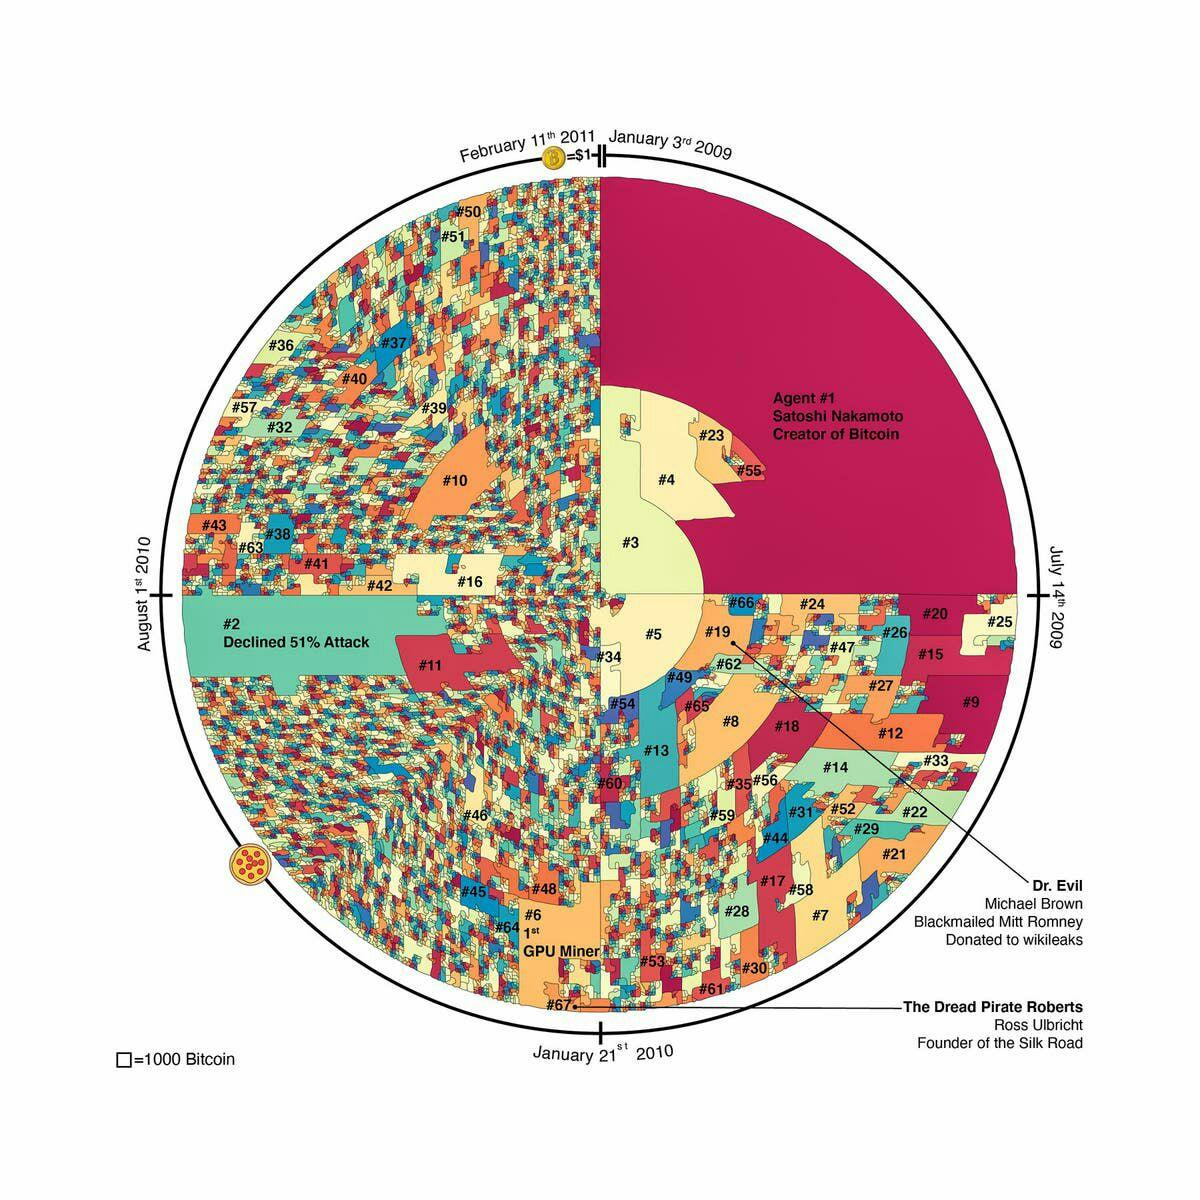

A map of the bitcoin blockchain constructed by Ms. Blackburn and Dr. Lieberman Aiden using data leakages.
“Each agent corresponds to a single map tile, whose area is proportional to the quantity of bitcoin mined by
the agent,” they noted in their recent paper. Alyssa Blackburn and Erez Lieberman Aiden [link](https://www.nytimes.com/2022/06/06/science/bitcoin-nakamoto-blackburn-crypto.html)


**Coinbase transaction mining address clustering heuristic**

We can assume that the output address of a Coinbase transaction is controlled by the same entity (the miner that mines the block). There is no reason to send the block reward to non-proper addresses

**Common-input-ownership heuristic**

This is a heuristic or assumption which says that if a transaction has more than one input then all those inputs are owned by the same entity.
For example, consider this transaction with inputs A, B and C; and outputs X and Y.

    A (1 btc) --> X (4 btc)
    B (2 btc)     Y (2 btc)
    C (3 btc)
This transaction would be an indication that addresses B and C are owned by the same person who owns address A.
One of the purposes of CoinJoin is to break this heuristic.

**Single input and single output heuristic**

transactions with a single input and a single output are interpreted as a movement of funds from one wallet to another under the control of the same owner. This heuristic fails if the transaction is actually a payment without change. This heuristic has a greater value when the funds moved from A to B equals the entire balance of wallet A.

    A (1 btc) --> B (1 btc)

**Consolidation transaction heuristic**

    A (1 btc) --> X (6 btc)
    B (2 btc)     
    C (3 btc)

A transaction with multiple inputs and a single output is interpreted as a consolidation transaction, where all input UTXOs venerate a single output UTXO. This operation reveals that all transaction addresses belong to the same entity. This heuristic fails if the transaction is actually a payment without change.



**Payment transaction with amount payed and change address heuristic**

    A (10 btc) --> X (6 btc)
                   y (4 btc)

the most common transactions are those with one or more inputs and two outputs, where the two outputs represent the payment that A makes to B and the change of the payment that returns to A. We need to identify the change of the transition.


**Change address detection heuristic**

has the objective of identifying the change in the Payment transactions. To do this, different heuristics are used:
- same address in input and output heuristic
- address reuse heuristic
- Unnecessary input heuristic
- new address in output heuristic
- round number heuristic


**same address in input and output heuristic**

if in the output addresses there is an address of the entity that owns the input addresses, then the change is that address. The user reused that address to collect the change of the transaction.

**address reuse heuristic**

If an output address has been reused it is very likely to be a payment output, not a change output. This is because change addresses are created automatically by wallet software but payment addresses are manually sent between humans. The address reuse would happen because the human user reused an address out of ignorance or apathy. This heuristic is probably the most accurate, as it is very hard to imagine how false positives would arise (except by intentional design of wallets). This heuristic is also called the "shadow heuristic"

**Unnecessary input heuristic**

Also called the "optimal change heuristic". Consider this bitcoin transaction. It has two inputs worth 2 BTC and 3 BTC and two outputs worth 4 BTC and 1 BTC.

    2 btc --> 4 btc
    3 btc     1 btc
Assuming one of the outputs is change and the other output is the payment. There are two interpretations: the payment output is either the 4 BTC output or the 1 BTC output. But if the 1 BTC output is the payment amount then the 3 BTC input is unnecessary, as the wallet could have spent only the 2 BTC input and paid lower miner fees for doing so. This is an indication that the real payment output is 4 BTC and that 1 BTC is the change output.

This is an issue for transactions which have more than one input. One way to fix this leak is to add more inputs until the change output is higher than any input, for example:

    2 btc --> 4 btc
    3 btc     6 btc
    5 btc
Now both interpretations imply that some inputs are unnecessary. Unfortunately this costs more in miner fees and can only be done if the wallet actually owns other UTXOs.

Some wallets have a coin selection algorithm which violates this heuristic. An example might be because the wallets want to consolidate inputs in times of cheap miner fees. So this heuristic is not decisive evidence.

**new address in output heuristic**

If in the output addresses there is only one address that is used for the first time, then this is the change address

**round number heuristic**

Many payment amounts are round numbers, for example 1 BTC or 0.1 BTC. The leftover change amount would then be a non-round number (e.g. 1.78213974 BTC). This potentially useful for finding the change address. 

**Mixed transaction recognition heuristic**

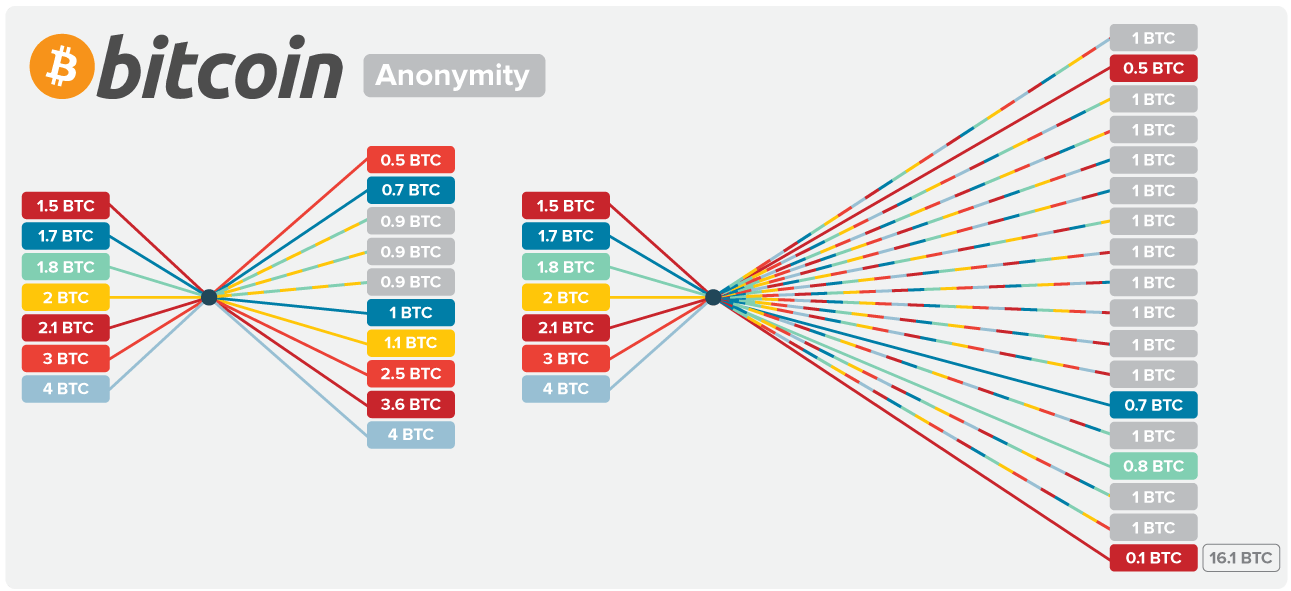

mixed transactions have many inputs and many outputs. Typically the outputs are characterized by the same amount of btc, making coinjoin sudoku and taint analysis difficult. These transactions break the chain analysis. In the clustering process we limit ourselves to identifying the mixed transactions in order not to apply the heuristics. we limit ourselves to only applying a single iteration of taint analysis

**taint analysis and coinjoin sudoku**

Equal-output-CoinJoin transactions trivially reveal the change address because it is the outputs which are not equal-valued. For example consider this equal-output-coinjoin:

                  A (1btc)
    X (5btc) ---> B (1btc)
    Y (3btc)      C (4btc)
                  D (2btc)
There is a very strong indication that output D is change belongs to the owner of input Y, while output C is change belonging to input X. However, CoinJoin breaks the common-input-ownership heuristic and effectively hides the ownership of payment outputs (A and B), so the tradeoffs are still heavily in favour of using coinjoin.

### **4.5.3.** Bitcoin Address Clustering Algorithm


In [36]:
def input_addresses(G, tx_id):
    s = set()
    for src, dst in G.in_edges(tx_id):
        for arrow_info in G[src][dst].values():
            s.add(arrow_info['address'])
    return s

def output_addresses(G, tx_id):
    s = set()
    for src, dst in G.out_edges(tx_id):
        for arrow_info in G[src][dst].values():
            s.add(arrow_info['address'])
    return s

def in_degree_tx(G, tx_id):
    return len(input_addresses(G, tx_id))

def out_degree_tx(G, tx_id):
    return len(output_addresses(G, tx_id))

def is_coinbase_tx(G, tx_id):
  for src, dst in G.in_edges(tx_id):
    if src[:5] == 'coinb':
      return True
  return False

def is_mined_by_satoshi(G, tx_id, nodeDict, addressDict, start_block):
    return is_coinbase_tx(G, tx_id) and start_block == 0 and nodeDict[tx_id]['block_height'] < 21000 and len({addr for addr in output_addresses(G, tx_id) if addressDict[addr]['utilization'] <= 2}) == len(output_addresses(G, tx_id))

def is_mined_by_miner(G, tx_id):
    return is_coinbase_tx(G, tx_id)

def is_consolidation_tx(G, tx_id):
    return out_degree_tx(G, tx_id) == 1

def is_payment_tx(G, tx_id):
    return out_degree_tx(G, tx_id) == 2

def is_tx_with_change(G, tx_id, addr_clust):
    return not is_coinbase_tx(G, tx_id) and not is_coinjoin_tx(G, tx_id, addr_clust) and out_degree_tx(G, tx_id) > 1

def is_coinjoin_tx(G, tx_id, addr_clust):
    if not is_coinbase_tx(G, tx_id):
        in_addrs = input_addresses(G, tx_id)
        out_addrs = output_addresses(G, tx_id)
        in_cluster_set = {addr_clust[addr] for addr in in_addrs}
        return len(in_cluster_set) == len(in_addrs) and len(out_addrs) >= 10
    return False

def taint_analysis(G, tx_id):
    input = set()
    for src, dst in G.in_edges(tx_id):
        for arrow_info in G[src][dst].values():
            input.add((arrow_info['address'], arrow_info['value']))
    output = set()
    for src, dst in G.out_edges(tx_id):
        for arrow_info in G[src][dst].values():
            output.add((arrow_info['address'], arrow_info['value']))
    if len(input) > 1:
        first_max = builtins.max(input, key=lambda x: x[1])
        input.remove(first_max)
        second_max = builtins.max(input, key=lambda x: x[1])
        possible_address = {tup[0] for tup in output if tup[1] > second_max[1] and tup[1] < first_max[1]}
        if len(possible_address) == 1:
            return [{possible_address.pop(), first_max[0]}]
    return []

def find_change_address(G, tx_id, nodeDict, addressDict, addr_clust, clust_addr):

    input = set()
    for src, dst in G.in_edges(tx_id):
        for arrow_info in G[src][dst].values():
            input.add((arrow_info['address'], arrow_info['value']))
    output = set()
    for src, dst in G.out_edges(tx_id):
        for arrow_info in G[src][dst].values():
            output.add((arrow_info['address'], arrow_info['value']))

    in_cluster_set = {addr_clust[addr] for addr, _ in input}
    out_cluster_set = {addr_clust[addr] for addr, _ in output}
    intersection_cluster_set = in_cluster_set.intersection(out_cluster_set)

    if intersection_cluster_set != set():
        # same address in input and output heuristic
        for cluster_id in intersection_cluster_set:
            for addr in clust_addr[cluster_id]:
                for a, _ in output:
                    if addr == a:
                        return addr

    else:
        possible_change_addresses = set()

        # Unnecessary input heuristic
        for out in output:
            flag = False
            for inp in input:
                if out[1] < inp[1]:
                    flag = True
                    break
            if flag:
                possible_change_addresses.add(out[0])
        if len(possible_change_addresses) == 1:
            return possible_change_addresses.pop()
        
        # new address in output heuristic
        new_addrs = {addr for addr, _ in output if nodeDict[tx_id]['temporal_index'] == addressDict[addr]['birthday']}
        if len(new_addrs) == 1:
            return new_addrs.pop()
        else:
            possible_change_addresses = possible_change_addresses.union(new_addrs)

        # round number heuristic
        if len(output) == 2:
            o1, o2 = output.pop(), output.pop()
            s1 = str(o1[1]).strip('0').strip('.')
            s2 = str(o1[1]).strip('0').strip('.')
            l1 = len(s1.split('.')[1]) if '.' in s1 else 0 
            l2 = len(s2.split('.')[1]) if '.' in s2 else 0 
            if l1-3 > l2:
                return o1[0]
            if l2-3 > l1:
                return o2[0]
        
        # address reuse heuristic
        possible_change_addresses = {addr for addr in possible_change_addresses if addressDict[addr]['utilization'] <= 2}
        if len(possible_change_addresses) == 1:
            return possible_change_addresses.pop()
    return None

def apply_hard_heuristics(G, tx_id, nodeDict, addressDict, addr_clust, clust_addr):
    if is_tx_with_change(G, tx_id, addr_clust):
        # Change address detection heuristic
        # Common-input-ownership heuristic
        change_address = find_change_address(G, tx_id, nodeDict, addressDict, addr_clust, clust_addr)
        if change_address != None:
            return [input_addresses(G, tx_id).union({change_address})]
        else:
            return [input_addresses(G, tx_id)]
    # Mixed transaction recognition heuristic
    if is_coinjoin_tx(G, tx_id, addr_clust):
        # taint analysis and coinjoin sudoku
        return taint_analysis(G, tx_id)
    return []

def apply_simple_heuristics(G, tx_id, start_block, nodeDict, addressDict):
    if is_mined_by_satoshi(G, tx_id, nodeDict, addressDict, start_block):
        # Satoshi heuristic
        return [output_addresses(G, tx_id).union({'1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa'})]
    if is_mined_by_miner(G, tx_id): 
        # Coinbase transaction mining address clustering heuristic
        return [output_addresses(G, tx_id)]
    if is_consolidation_tx(G, tx_id):
        # Single input and single output heuristic
        # Common-input-ownership heuristic
        # Consolidation transaction heuristic
        return [input_addresses(G, tx_id).union(output_addresses(G, tx_id))]
    if is_payment_tx(G, tx_id):
        # Common-input-ownership heuristic
        # Payment transaction with amount payed and change address
        return [input_addresses(G, tx_id)]
    return []

def merge_clusters(list_of_grouped_addresses_sets, addr_clust, clust_addr):
    for grouped_addresses_set in list_of_grouped_addresses_sets:
        cluster_id_to_merge = set(addr_clust[address] for address in grouped_addresses_set)
        common_cluster_id = cluster_id_to_merge.pop()
        
        for cluster_id in cluster_id_to_merge:
            clust_addr[common_cluster_id] = clust_addr[common_cluster_id].union(clust_addr[cluster_id])

            for address in clust_addr[cluster_id]:
                addr_clust[address] = common_cluster_id
            
            del clust_addr[cluster_id]
    return

def address_clustering(G, a_df, known_tx_df, spark_session, start_block, debug=False):
    
    if debug: print('initialing for clustering...')
    addr_clust = {row.address : row.cluster_id for row in a_df.rdd.collect()}
    clust_addr = {row.cluster_id : {row.address} for row in a_df.rdd.collect()}
    list_of_grouped_addresses_sets = []
    addressDict = dict()
    nodeDict = dict()
    
    for i, tx in known_tx_df.sort('temporal_index').toPandas().iterrows():
        nodeDict[str(tx.id)] = {'temporal_index' : tx.temporal_index, 'block_height' : tx.block_height} 
        for address in output_addresses(G, str(tx.id)).union(input_addresses(G, str(tx.id))):
            try:
                addressDict[address]['utilization'] += 1
            except KeyError:
                addressDict[address] = {'birthday' : tx.temporal_index, 'utilization' : 1}
    if debug: print('number of clusters at starting point: {}'.format(len(clust_addr)))

    if debug: print('apply simple heuristics...')
    for i, tx in known_tx_df.sort('temporal_index').toPandas().iterrows():
        if debug and i % 100000 == 0: print('clustering tx number {}'.format(i))
        list_of_grouped_addresses_sets = apply_simple_heuristics(G, str(tx.id), start_block, nodeDict, addressDict)
        merge_clusters(list_of_grouped_addresses_sets, addr_clust, clust_addr)
    
    if debug: print('number of clusters after simple heuristic: {}'.format(len(clust_addr)))

    if debug: print('apply hard heuristics...')
    for i, tx in known_tx_df.sort('temporal_index').toPandas().iterrows():
        if debug and i % 100000 == 0: print('clustering tx number {}'.format(i))
        list_of_grouped_addresses_sets = apply_hard_heuristics(G, str(tx.id), nodeDict, addressDict, addr_clust, clust_addr)
        merge_clusters(list_of_grouped_addresses_sets, addr_clust, clust_addr)
    
    if debug: print('number of clusters after hard heuristic: {}'.format(len(clust_addr)))

    a_df = spark_session.createDataFrame(addr_clust.items(), ['address', 'cluster_id'])
    return a_df

In [37]:
a_df = address_clustering(nx_graph, a_df, known_tx_df, spark, start_block, debug=True)

initialing for clustering...
number of clusters at starting point: 416792
apply simple heuristics...
clustering tx number 0
clustering tx number 100000
clustering tx number 200000
clustering tx number 300000
clustering tx number 400000
number of clusters after simple heuristic: 251725
apply hard heuristics...
clustering tx number 0
clustering tx number 100000
clustering tx number 200000
clustering tx number 300000
clustering tx number 400000
number of clusters after hard heuristic: 127254


In [38]:
shutil.rmtree(os.path.join(d_path, 'addresses-{}-{}'.format(start_block, end_block)))
a_df.write.save(path=a_path, format='csv', header='True')

# **5. Results**

## **5.1.** Overview

In [39]:
a_df.createOrReplaceTempView('ADDRESS')
entity_df = spark.sql("select min(address) as representative, cluster_id as entity_id, count(cluster_id) as n_address_collected from ADDRESS group by cluster_id order by -count(cluster_id)")

In [40]:
print(entity_df.count())
entity_df.printSchema()
entity_df.show(truncate=False)

127254
root
 |-- representative: string (nullable = true)
 |-- entity_id: long (nullable = true)
 |-- n_address_collected: long (nullable = false)

+----------------------------------+-----------+-------------------+
|representative                    |entity_id  |n_address_collected|
+----------------------------------+-----------+-------------------+
|11126yHiXjavR3oNVwV2GRNso2ah4MnZtm|25769853864|198382             |
|1123NonCacE6WuDvBbeGhW3Ywx6S9w3Cdj|25769824176|3475               |
|112TjWaMqEcKYFzcjZ6VJKow4ojjviwRpU|60129584408|1039               |
|112qmkJhmTo6S33FRPFkqkWCfN5Q3FzRw1|34359777952|996                |
|112xSpB6Wgugt7qrQ5UwqKfaRuf7LZkY7K|51539616384|805                |
|114AoTxSF5vZoY1p6QEaH87vpqqhGKPks1|25769853120|782                |
|11T4T33P9VAfE27dB1iWfdC8RevzqymNU |51539642808|762                |
|11377fTiDHusaPRc6dtJU1qWmuPVhbkEmS|17179907776|697                |
|113u4fUSYDNqHHQ4js7CN4GEiN6LCDfff9|34359777160|596                |
|112VV2wHYjcL2JUidskk7s4

In [41]:
entity_df.createOrReplaceTempView('ENTITY')
statistics_entity_df = spark.sql("select n_address_collected as entity_dimention, count(n_address_collected) as n_entities from ENTITY group by n_address_collected order by n_address_collected")

In [42]:
print(statistics_entity_df.count())
statistics_entity_df.printSchema()
statistics_entity_df.show(statistics_entity_df.count(), truncate=False)

162
root
 |-- entity_dimention: long (nullable = false)
 |-- n_entities: long (nullable = false)

+----------------+----------+
|entity_dimention|n_entities|
+----------------+----------+
|1               |107504    |
|2               |11142     |
|3               |2438      |
|4               |2350      |
|5               |694       |
|6               |945       |
|7               |289       |
|8               |350       |
|9               |180       |
|10              |147       |
|11              |124       |
|12              |91        |
|13              |86        |
|14              |78        |
|15              |52        |
|16              |53        |
|17              |32        |
|18              |42        |
|19              |27        |
|20              |26        |
|21              |38        |
|22              |25        |
|23              |19        |
|24              |16        |
|25              |18        |
|26              |16        |
|27              |25        |
|2

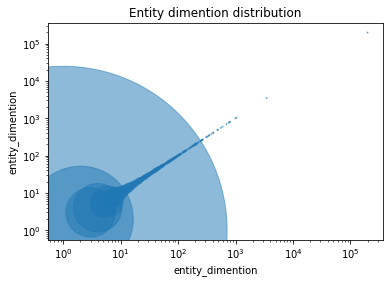

In [43]:
plt.scatter(
    x = statistics_entity_df.toPandas()['entity_dimention'], 
    y = statistics_entity_df.toPandas()['entity_dimention'], 
    s=statistics_entity_df.toPandas()['n_entities'], 
    alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("entity_dimention")
plt.ylabel("entity_dimention")
plt.title("Entity dimention distribution")
plt.show()

## **5.2.** Assumption

the implemented clustering algorithm aims to reduce false positives as much as possible, that is, it avoids as much as possible the union of two addresses belonging to different entities. So the algorithm doesn't risk merging between two clusters. This results in many clusters populated by only one or two addresses. since it is unusual for a single entity to possess only one or two addresses, it is reasonable to assume that these small clasters can somehow be joined to larger entities through stronger clustering and more trivial analyzes.

For this reason, in some use cases, if necessary it is possible not to consider small clusters, assuming that these are incorporated into larger clusters.

In [44]:
entity_df.createOrReplaceTempView('ENTITY')
tmp_df = spark.sql("select entity_id from ENTITY where n_address_collected > 1")
a2_df = a_df.join(tmp_df, a_df.cluster_id == tmp_df.entity_id, 'inner').select('address', 'cluster_id')

In [45]:
print(a2_df.count())
a2_df.printSchema()
a2_df.show(truncate=False)

309288
root
 |-- address: string (nullable = true)
 |-- cluster_id: long (nullable = true)

+----------------------------------+-----------+
|address                           |cluster_id |
+----------------------------------+-----------+
|1Hq6vXaLv6e58ifAbP7YFjVRUA1igkSMrz|60129544699|
|1CutLZRCJvPUcF9T4Wzs859zPtZhKFQEni|60129550501|
|16jxgzEC7VCt9TvQZHMAQAXebYz2mYQj4y|60129544699|
|1ETYFFcFztVvpPx3jGGNxRabrPYw57qRnE|42949684225|
|115sJ226v2ncrqHC5F1vXMz2DHoaHSDaE9|51539656728|
|16izFWKyu2AY6ycMu453NNYkhvk9Cw9w68|34359751784|
|1HAQpTD3ZHCjFbTaigPFJTkRe1BQd9eUyL|60129558315|
|12zvxuLZdWvBerij3Ng3uBtMpJojKFBrFd|42949687280|
|1JjvfHfERsnkfyuAHrdu3LMV4UB9VqLUV9|42949687592|
|1MUoGs6BahQUKfkvCYaK67KEHScszCRc8x|34359747761|
|13szEL74puuEaKpTRpHDL3aH8mjsJtcyc4|42949687592|
|1F3oWzWE2phoJ5f3ZmmiT9yUcQWSHfjvQM|25769821315|
|15E2o9gwNUjLdXunAiD11fBknyfoeqGLG4|60129562010|
|1N89rh4zhheAfegnCE5dz7z5nV1ju5rAdR|60129562342|
|12KMyo8yybvBf7Tu7srvPmCPKYFmHyxBry|42949691248|
|18YdDBkrhJ3NmPJ5pTLKgxnke

## **5.3.** Overview after Assumption

In [46]:
a2_df.createOrReplaceTempView('ADDRESS')
entity_df = spark.sql("select min(address) as representative, cluster_id as entity_id, count(cluster_id) as n_address_collected from ADDRESS group by cluster_id order by -count(cluster_id)")

In [47]:
print(entity_df.count())
entity_df.printSchema()
entity_df.show(truncate=False)

19750
root
 |-- representative: string (nullable = true)
 |-- entity_id: long (nullable = true)
 |-- n_address_collected: long (nullable = false)

+----------------------------------+-----------+-------------------+
|representative                    |entity_id  |n_address_collected|
+----------------------------------+-----------+-------------------+
|11126yHiXjavR3oNVwV2GRNso2ah4MnZtm|25769853864|198382             |
|1123NonCacE6WuDvBbeGhW3Ywx6S9w3Cdj|25769824176|3475               |
|112TjWaMqEcKYFzcjZ6VJKow4ojjviwRpU|60129584408|1039               |
|112qmkJhmTo6S33FRPFkqkWCfN5Q3FzRw1|34359777952|996                |
|112xSpB6Wgugt7qrQ5UwqKfaRuf7LZkY7K|51539616384|805                |
|114AoTxSF5vZoY1p6QEaH87vpqqhGKPks1|25769853120|782                |
|11T4T33P9VAfE27dB1iWfdC8RevzqymNU |51539642808|762                |
|11377fTiDHusaPRc6dtJU1qWmuPVhbkEmS|17179907776|697                |
|113u4fUSYDNqHHQ4js7CN4GEiN6LCDfff9|34359777160|596                |
|112VV2wHYjcL2JUidskk7s47

In [48]:
entity_df.createOrReplaceTempView('ENTITY')
statistics_entity_df = spark.sql("select n_address_collected as entity_dimention, count(n_address_collected) as n_entities from ENTITY group by n_address_collected order by n_address_collected")

In [49]:
print(statistics_entity_df.count())
statistics_entity_df.printSchema()
statistics_entity_df.show(statistics_entity_df.count(), truncate=False)

161
root
 |-- entity_dimention: long (nullable = false)
 |-- n_entities: long (nullable = false)

+----------------+----------+
|entity_dimention|n_entities|
+----------------+----------+
|2               |11142     |
|3               |2438      |
|4               |2350      |
|5               |694       |
|6               |945       |
|7               |289       |
|8               |350       |
|9               |180       |
|10              |147       |
|11              |124       |
|12              |91        |
|13              |86        |
|14              |78        |
|15              |52        |
|16              |53        |
|17              |32        |
|18              |42        |
|19              |27        |
|20              |26        |
|21              |38        |
|22              |25        |
|23              |19        |
|24              |16        |
|25              |18        |
|26              |16        |
|27              |25        |
|28              |11        |
|2

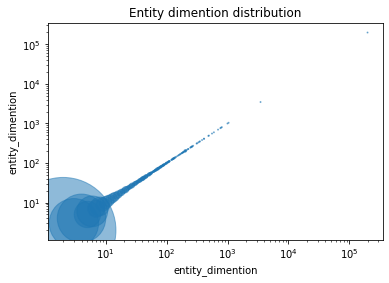

In [50]:
plt.scatter(
    x = statistics_entity_df.toPandas()['entity_dimention'], 
    y = statistics_entity_df.toPandas()['entity_dimention'], 
    s=statistics_entity_df.toPandas()['n_entities'], 
    alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("entity_dimention")
plt.ylabel("entity_dimention")
plt.title("Entity dimention distribution")
plt.show()

# **6. Boosting Bitcoin Address Clustering with other more complex techniques**

## **6.1.** Merge or Demerge clusters thanks to off-chain informations

In [51]:
satoshi = {'1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa', '12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S'}
lazslo = {'1Q2TWHE3GMdB6BZKafqwxXtWAWgFt5Jvm3', '1XPTgDRhN8RFnzniWCddobD9iKZatrvH4'}

## **6.2.** Louvain community detection algorithm

# **7. Use cases**

## **7.1.** Visualize entity movements from an address

In [52]:
address = '12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S'
ClusterList = None
try:
    a_df.createOrReplaceTempView('ADDRESSES')
    cluster_id = spark.sql("select cluster_id from ADDRESSES where address = '"+address+"'").head().cluster_id
    a_df.createOrReplaceTempView('ADDRESSES')
    ClusterList = spark.sql("select address from ADDRESSES where cluster_id = " + str(cluster_id)).withColumnRenamed('address', 'address_clustered')
    print('address {} is in cluster {}'.format(address, cluster_id))
except:
    print('invalid address')

address 12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S is in cluster 51539615536


In [53]:
new_e_df = e_df.join(ClusterList, e_df.address == ClusterList.address_clustered, 'inner').drop('address_clustered')
tmp_df = new_e_df.select(new_e_df.src_id).union(new_e_df.select(new_e_df.dst_id)).withColumnRenamed('src_id', 'tmp_id').distinct()
new_v_df = v_df.join(tmp_df, v_df.id == tmp_df.tmp_id, 'inner').drop('tmp_id')
tmp_df = new_v_df.select('id')
new_e_df = e_df.join(tmp_df, tmp_df.id == e_df.src_id, 'inner').union(e_df.join(tmp_df, tmp_df.id == e_df.dst_id, 'inner')).drop('id').distinct()
tmp_df = new_e_df.select(new_e_df.src_id).union(new_e_df.select(new_e_df.dst_id)).distinct().withColumnRenamed('src_id', 'tmp_id')
new_v_df = v_df.join(tmp_df, v_df.id == tmp_df.tmp_id).drop('tmp_id')

In [ ]:
print("Total nodes: {}".format(new_v_df.count()))
print("Total edges: {}".format(new_e_df.count()))

In [ ]:
new_v_df.show(truncate=False)
new_e_df.show(truncate=False)

In [ ]:
def generate_pyvis_graph(v_df, e_df, a_df, cluster_id_selected):
    addr_clust = {row.address : row.cluster_id for row in a_df.rdd.collect()}
    net = Network(
                height='100%',
                width='80%',
                directed=True
                )
    net.show_buttons(filter_=["physics"])

    for node in v_df.rdd.collect():
        if node.note == 'tx':
            title = 'tx_hash: {}\n'.format(node.tx_hash) + \
                'block_height: {}\n'.format(node.block_height) + \
                'n_input: {}\n'.format(node.n_input) + \
                'n_output: {}\n'.format(node.n_output) + \
                'amount_input: {} BTC\n'.format(node.amount_input/100000000) + \
                'amount_output: {} BTC\n'.format(node.amount_output/100000000) + \
                'fee: {} BTC'.format(node.fee/100000000)
            net.add_node(n_id=str(node.id), shape='dot', title=title)
        elif node.note == 'UTXO':
            title = '{}\n'.format(node.note) + \
                'amount: {} BTC'.format(node.amount_input/100000000)
            net.add_node(n_id=str(node.id), shape='square', title=title)
        elif node.note == 'coinbase':
            title = '{}\n'.format(node.note) + \
                'amount: {} BTC'.format(node.amount_output/100000000)
            net.add_node(n_id=str(node.id), shape='square', title=title)
        elif node.note == 'unknown_tx':
            title = 'unknown_tx\n' + 'tx_index: {}'.format(node.id)
            net.add_node(n_id=str(node.id), shape='square', title=title)
    for edge in e_df.rdd.collect():
        if edge.address[:4] != 'UTXO' and edge.address[:4] != 'coin':
            title = 'address: {}\n'.format(edge.address) + \
                    'value: {} BTC\n'.format(edge.value/100000000) + \
                    'cluster_id : {}'.format(addr_clust[edge.address])
            if addr_clust[edge.address] == cluster_id_selected:
                net.add_edge(source=str(edge.src_id), to=str(edge.dst_id), title=title, value=edge.value/100000000, color='red')
            else:
                net.add_edge(source=str(edge.src_id), to=str(edge.dst_id), title=title, value=edge.value/100000000)
        else:
            title = 'address: {}\n'.format(edge.address) + \
                    'value: {} BTC\n'.format(edge.value/100000000)
            net.add_edge(source=str(edge.src_id), to=str(edge.dst_id), title=title, value=edge.value/100000000)
    return net

In [ ]:
new_pyvis_graph = generate_pyvis_graph(new_v_df, new_e_df, a_df, cluster_id)
new_pyvis_graph.write_html(os.path.join(d_path, 'cluster_graph-{}-{}.html'.format(start_block, end_block)))

## **7.2.** Solve specific Queries

### **7.2.1.** How "Trustless" Is Bitcoin, Really? ([link](https://www.nytimes.com/2022/06/06/science/bitcoin-nakamoto-blackburn-crypto.html))

In [ ]:
entity_df.createOrReplaceTempView('ENTITY')
tmp_df = spark.sql("select entity_id from ENTITY where n_address_collected > 2")
a3_df = a_df.join(tmp_df, a_df.cluster_id == tmp_df.entity_id, 'inner').select('address', 'cluster_id')

e_df.createOrReplaceTempView('EDGES')
coinbase_tx_id_df = spark.sql("select dst_id as tmp_id from EDGES where src_id like 'coinbase%'")
miners_addrs_df = e_df.join(coinbase_tx_id_df, e_df.src_id == coinbase_tx_id_df.tmp_id).select('address').withColumnRenamed('address', 'miner_address')
tmp_df = a3_df.join(miners_addrs_df, a3_df.address == miners_addrs_df.miner_address, 'inner').drop('miner_address')
tmp_df.createOrReplaceTempView('TMP')
miners_entities_df = spark.sql("select min(address) as representative, cluster_id, count(cluster_id) as n_address_collected from TMP group by cluster_id")

In [ ]:
miners_entities_df.count()

### **7.2.2.** Any other Queries you can immagine

# **8. Web App**

In [ ]:
import streamlit as st
import streamlit.components.v1 as components
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import requests
import wget
import csv
import os
from urllib import request
from urllib.error import HTTPError
from pyvis.network import Network
import base64
from PIL import Image

def generate_pyvis_graph(v_df, e_df, a_df, cluster_id_selected):
    addr_clust = {row.address : row.cluster_id for row in a_df.rdd.collect()}
    net = Network(
                height='100%',
                width='80%',
                directed=True
                )
    net.show_buttons(filter_=["physics"])

    for node in v_df.rdd.collect():
        if node.note == 'tx':
            title = 'tx_hash: {}\n'.format(node.tx_hash) + \
                'block_height: {}\n'.format(node.block_height) + \
                'n_input: {}\n'.format(node.n_input) + \
                'n_output: {}\n'.format(node.n_output) + \
                'amount_input: {} BTC\n'.format(node.amount_input/100000000) + \
                'amount_output: {} BTC\n'.format(node.amount_output/100000000) + \
                'fee: {} BTC'.format(node.fee/100000000)
            net.add_node(n_id=str(node.id), shape='dot', title=title)
        elif node.note == 'UTXO':
            title = '{}\n'.format(node.note) + \
                'amount: {} BTC'.format(node.amount_input/100000000)
            net.add_node(n_id=str(node.id), shape='square', title=title)
        elif node.note == 'coinbase':
            title = '{}\n'.format(node.note) + \
                'amount: {} BTC'.format(node.amount_output/100000000)
            net.add_node(n_id=str(node.id), shape='square', title=title)
        elif node.note == 'unknown_tx':
            title = 'unknown_tx\n' + 'tx_index: {}'.format(node.id)
            net.add_node(n_id=str(node.id), shape='square', title=title)
    for edge in e_df.rdd.collect():
        if edge.address[:4] != 'UTXO' and edge.address[:4] != 'coin':
            title = 'address: {}\n'.format(edge.address) + \
                    'value: {} BTC\n'.format(edge.value/100000000) + \
                    'cluster_id : {}'.format(addr_clust[edge.address])
            if addr_clust[edge.address] == cluster_id_selected:
                net.add_edge(source=str(edge.src_id), to=str(edge.dst_id), title=title, value=edge.value/100000000, color='red')
            else:
                net.add_edge(source=str(edge.src_id), to=str(edge.dst_id), title=title, value=edge.value/100000000)
        else:
            title = 'address: {}\n'.format(edge.address) + \
                    'value: {} BTC\n'.format(edge.value/100000000)
            net.add_edge(source=str(edge.src_id), to=str(edge.dst_id), title=title, value=edge.value/100000000)
    return net

def render_svg(svg_file):
    with open(svg_file, "r") as f:
        lines = f.readlines()
        svg = "".join(lines)
        b64 = base64.b64encode(svg.encode("utf-8")).decode("utf-8")
        html = r'<img src="data:image/svg+xml;base64,%s"/>' % b64
        html = '<p style="text-align:center;">' + html + '</p>'
        return html










def main(start_block, end_block):

    print('executing main')

    DIR = './'

    spark = SparkSession.builder.getOrCreate()
    d_path = os.path.join(DIR, 'blocks-{}-{}-clustered'.format(start_block, end_block))
    e_path = os.path.join(d_path, 'edges-{}-{}'.format(start_block, end_block))
    v_path = os.path.join(d_path, 'vertices-{}-{}'.format(start_block, end_block))
    a_path = os.path.join(d_path, 'addresses-{}-{}'.format(start_block, end_block))
    e_df = spark.read.load(e_path,
                            format="csv",
                            sep=",",
                            inferSchema="true",
                            header="true"
                            )
    v_df = spark.read.load(v_path,
                            format="csv",
                            sep=",",
                            inferSchema="true",
                            header="true"
                            )
    unknown_v_df = e_df.select('src_id').union(e_df.select('dst_id')).distinct().subtract(v_df.select('id')).withColumnRenamed('src_id', 'id')
    unknown_v_df = unknown_v_df.withColumn('note', lit('unknown_tx')) \
                            .withColumn('tx_hash', lit(None)) \
                            .withColumn('block_height', lit(-1)) \
                            .withColumn('block_hash', lit(None)) \
                            .withColumn('fee', lit(0)) \
                            .withColumn('n_input', lit(0)) \
                            .withColumn('amount_input', lit(0)) \
                            .withColumn('n_output', lit(0)) \
                            .withColumn('amount_output', lit(0)) \
                            .withColumn('temporal_index', lit(-1))
    v_df = v_df.union(unknown_v_df)
    a_df = spark.read.load(a_path,
                            format="csv",
                            sep=",",
                            inferSchema="true",
                            header="true"
                            )

    img = Image.open('Bitcoin.png')
    st.set_page_config(
        page_title="Bitcoin Address Clustering",
        layout="wide",
        page_icon=img
    )

    st.title('Bitcoin Address Clustering\n')
    with st.container():
        c1, c2 = st.columns(2)
        c1.subheader('''
                Enter a bitcoin address to be clustered using the following heuristics:\n
                - Satoshi heuristic\n
                - Coinbase transaction mining address clustering heuristic\n
                - Common-input-ownership heuristic\n
                - Single input and single output heuristic\n
                - Consolidation transaction heuristic\n
                - Payment transaction with amount payed and change address heuristic\n
                - Change address detection heuristic\n
                \t- same address in input and output heuristic\n
                \t- address reuse heuristic\n
                \t- Unnecessary input heuristic\n
                \t- new address in output heuristic\n
                \t- round number heuristic\n
                - Mixed transaction recognition heuristic\n
                \t- taint analysis and coinjoin sudoku
                ''')

        c2.markdown(render_svg('bitcoin-img.svg'), unsafe_allow_html=True)
        c2.write('\n\n\n\n')

        with c2.form(key='form'):
            address = st.text_input(label='Insert address to cluster')
            submit_button = st.form_submit_button(label='Start Clustering')

    if submit_button:
        with st.spinner("Loading..."):

            a_df.createOrReplaceTempView('ADDRESSES')
            if spark.sql("select * from ADDRESSES where address = '"+address+"'").rdd.isEmpty():
                print('invalid address')
                st.error('Invalid address')
            else:
                a_df.createOrReplaceTempView('ADDRESSES')
                cluster_id = spark.sql("select cluster_id from ADDRESSES where address = '"+address+"'").head().cluster_id
                a_df.createOrReplaceTempView('ADDRESSES')
                ClusterList = spark.sql("select address from ADDRESSES where cluster_id = " + str(cluster_id)).withColumnRenamed('address', 'address_clustered')

                print('address {} is in cluster {}'.format(address, cluster_id))
                print('generating cluster graphs')

                new_e_df = e_df.join(ClusterList, e_df.address == ClusterList.address_clustered, 'inner').drop('address_clustered')
                tmp_df = new_e_df.select(new_e_df.src_id).union(new_e_df.select(new_e_df.dst_id)).withColumnRenamed('src_id', 'tmp_id').distinct()
                new_v_df = v_df.join(tmp_df, v_df.id == tmp_df.tmp_id, 'inner').drop('tmp_id')
                tmp_df = new_v_df.select('id')
                new_e_df = e_df.join(tmp_df, tmp_df.id == e_df.src_id, 'inner').union(e_df.join(tmp_df, tmp_df.id == e_df.dst_id, 'inner')).drop('id').distinct()
                tmp_df = new_e_df.select(new_e_df.src_id).union(new_e_df.select(new_e_df.dst_id)).distinct().withColumnRenamed('src_id', 'tmp_id')
                new_v_df = v_df.join(tmp_df, v_df.id == tmp_df.tmp_id).drop('tmp_id')

                new_pyvis_graph = generate_pyvis_graph(new_v_df, new_e_df, a_df, cluster_id)

                new_pyvis_graph.height = '800px'
                new_pyvis_graph.width = '2400px'
                new_pyvis_graph.write_html(os.path.join(d_path, 'cluster_graph-{}-{}.html'.format(start_block, end_block)))

                print('cluster graphs generated')
                print('display cluster')
                st.success("Done!")
                HtmlFile = open(os.path.join(d_path, 'cluster_graph-{}-{}.html'.format(start_block, end_block)), 'r', encoding='utf-8')
                components.html(HtmlFile.read(), height=800, scrolling=True)

                print('cluster displayed')
                
                st.subheader('Graph Nodes')
                st.dataframe(new_v_df.toPandas())
                st.subheader('Graph Edges')
                st.dataframe(new_e_df.toPandas())
                st.subheader('Clustered Addresses')
                st.dataframe(ClusterList.toPandas())

    print('end main')
    return

if __name__ == "__main__":
    start_block = 0
    end_block = 120000
    main(start_block, end_block)

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501